In [55]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import pygad
import itertools
import random
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams["figure.figsize"] = (10, 7)

In [56]:
data = pd.read_excel("sp500_historical_data2.xlsx")
data

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2022-04-01,273.750000,274.959991,262.670013,267.119995,266.870575,51723500,NVDA
1,2022-04-04,267.279999,275.579987,266.130005,273.600006,273.344543,39712000,NVDA
2,2022-04-05,272.540009,273.190002,258.200012,259.309998,259.067871,43661500,NVDA
3,2022-04-06,249.339996,253.000000,240.029999,244.070007,243.842117,70383300,NVDA
4,2022-04-07,244.410004,247.220001,234.779999,242.080002,241.853973,55799200,NVDA
...,...,...,...,...,...,...,...,...
5999,2023-04-11,76.800003,77.320000,76.059998,76.489998,76.489998,1380400,ENTG
6000,2023-04-12,77.309998,77.440002,72.029999,72.089996,72.089996,1635000,ENTG
6001,2023-04-13,72.150002,73.449997,71.839996,72.849998,72.849998,1338100,ENTG
6002,2023-04-14,72.970001,73.800003,71.110001,72.220001,72.220001,1145800,ENTG


In [57]:
df = data.copy()
start_date = "2023-04-01"
end_date = "2023-04-18"
df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
print(df)
df = df[["Symbol", "Date", "Close"]].rename(columns={"Close": "price"}).reset_index(drop=True)
tickers = df["Symbol"].unique()

tickers_map = {i : j for i,j in zip(tickers, range(len(tickers)))}
tickers_map_reverse = {j : i for i,j in zip(tickers, range(len(tickers)))}

df["ticker_index"]  = df["Symbol"].map(tickers_map)
firsts = (df.groupby('Symbol').transform('first'))
df["adj_price"] = df["price"] / firsts["price"]
df = df[["Symbol", "ticker_index", "Date", "adj_price"]]


           Date        Open        High         Low       Close   Adj Close  \
251  2023-04-03  275.089996  280.000000  273.359985  279.649994  279.649994   
252  2023-04-04  279.660004  280.000000  273.070007  274.529999  274.529999   
253  2023-04-05  268.290009  269.980011  263.950012  268.809998  268.809998   
254  2023-04-06  265.839996  270.799988  264.269989  270.369995  270.369995   
255  2023-04-10  268.230011  276.209991  266.690002  275.790009  275.790009   
...         ...         ...         ...         ...         ...         ...   
5999 2023-04-11   76.800003   77.320000   76.059998   76.489998   76.489998   
6000 2023-04-12   77.309998   77.440002   72.029999   72.089996   72.089996   
6001 2023-04-13   72.150002   73.449997   71.839996   72.849998   72.849998   
6002 2023-04-14   72.970001   73.800003   71.110001   72.220001   72.220001   
6003 2023-04-17   70.959999   71.830002   70.269997   71.730003   71.730003   

        Volume Symbol  
251   39871600   NVDA  
252

In [58]:
df.groupby("Symbol").count().sort_values("Date")

,ticker_index,Date,adj_price
Symbol,,,
DAPXX,1,1,1
ADI,10,10,10
TER,10,10,10
SWKS,10,10,10
STM,10,10,10
QCOM,10,10,10
ON,10,10,10
NXPI,10,10,10
NVDA,10,10,10


#### Genetic algorithm

Below we try to find the best combination of 10 stocks that give the best return over the defined time period

In [59]:
## Define fitness function and utils

def portfolio_generate(df, tickers):
    portfolio = df[df['ticker_index'].isin(tickers)]
    portfolio = portfolio.groupby("Date", as_index=False).sum()
    portfolio = portfolio.sort_values("Date")
    return portfolio

def portfolio_return(portfolio):
    first_price = portfolio["adj_price"].iloc[0]
    last_price = portfolio["adj_price"].iloc[-1]
    # print(f"last_price / first_price - 1: {last_price / first_price - 1}")
    return last_price / first_price - 1

def portfolio_risk(portfolio):
    portfolio["daily_change"] = portfolio["adj_price"].diff(1)
    portfolio["daily_change"] = portfolio["daily_change"] / portfolio["adj_price"]
    print("\n\ndaily_change: ", portfolio["daily_change"])
    # print("\n\nadj_price: ",portfolio["adj_price"])
    return portfolio["daily_change"].std()

def fitness_func(ga_instance, solution, solution_idx):
    portfolio = portfolio_generate(df, solution)
    ret = portfolio_return(portfolio)
    ris = portfolio_risk(portfolio)
    fitness = ret / ris
    print(f"portfolio: {portfolio}")
    #　print(f"ret: {ret}")
    # print(f"ris: {ris}")
    
    # print(f"fitness: {fitness}")
    return fitness

def visualize(df, solution):
    solution_fitness = fitness_func(None, solution, None)
    portfolio  = portfolio_generate(df, solution)
    portfolio["adj_price"] = (portfolio["adj_price"] / portfolio["adj_price"].iloc[0] ) * 100
    ax = portfolio.plot.line(x="Date", y="adj_price")
    ax.set_ylim(90, 190)
    ret = round(portfolio_return(portfolio) * 100, 1)
    ris = round(portfolio_risk(portfolio) * 100, 1)
    
    print(f"Parameters of the best solution : {[tickers_map_reverse[i] for i in solution]}")
    print(f"Return: {ret}%")
    print(f"Risk: {ris}%")
    print(f"Risk adjusted return = {round(solution_fitness,1)}%")


In [60]:
## Define Genetic Algorithm

fitness_function = fitness_func

num_generations = 30
num_genes = 10

sol_per_pop = 90
num_parents_mating =  50

init_range_low = 0
init_range_high = 26
gene_type = int

parent_selection_type = "sss"
keep_parents = 30

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 30

In [61]:
## Initiate and run genetic algorithm

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       allow_duplicate_genes=False,
                       random_seed=2)
ga_instance.run()
for i,j in zip (ga_instance.best_solutions, ga_instance.best_solutions_fitness):
  print([(tickers_map_reverse[k],k) for k in sorted(i)],j)



daily_change:  0         NaN
1   -0.020516
2   -0.016257
3   -0.004502
4    0.021142
5   -0.004474
6   -0.016037
7    0.009917
8    0.000091
9   -0.002207
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            79  10.000000           NaN
1 2023-04-04            79   9.798964     -0.020516
2 2023-04-05            79   9.642208     -0.016257
3 2023-04-06            79   9.598990     -0.004502
4 2023-04-10            79   9.806318      0.021142
5 2023-04-11            79   9.762638     -0.004474
6 2023-04-12            79   9.608549     -0.016037
7 2023-04-13            79   9.704787      0.009917
8 2023-04-14            79   9.705675      0.000091
9 2023-04-17            79   9.684298     -0.002207


daily_change:  0         NaN
1   -0.021919
2   -0.017791
3   -0.007245
4    0.019412
5   -0.003522
6   -0.015613
7    0.009182
8   -0.003164
9   -0.001794
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.016746
2   -0.018552
3   -0.008790
4    0.013449
5   -0.003801
6   -0.023992
7    0.008898
8   -0.001951
9   -0.005897
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03           147  10.000000           NaN
1 2023-04-04           147   9.835301     -0.016746
2 2023-04-05           147   9.656161     -0.018552
3 2023-04-06           147   9.572020     -0.008790
4 2023-04-10           147   9.702512      0.013449
5 2023-04-11           147   9.665771     -0.003801
6 2023-04-12           147   9.439303     -0.023992
7 2023-04-13           147   9.524051      0.008898
8 2023-04-14           147   9.505509     -0.001951
9 2023-04-17           147   9.449788     -0.005897


daily_change:  0         NaN
1   -0.019927
2   -0.016953
3   -0.008671
4    0.014313
5   -0.002954
6   -0.022793
7    0.012887
8   -0.003231
9   -0.006733
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.025803
2   -0.018647
3   -0.004682
4    0.029122
5   -0.005955
6   -0.020624
7    0.011094
8    0.000579
9    0.114422
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            87   8.000000           NaN
1 2023-04-04            87   7.798770     -0.025803
2 2023-04-05            87   7.656007     -0.018647
3 2023-04-06            87   7.620331     -0.004682
4 2023-04-10            87   7.848907      0.029122
5 2023-04-11            87   7.802443     -0.005955
6 2023-04-12            87   7.644781     -0.020624
7 2023-04-13            87   7.730543      0.011094
8 2023-04-14            87   7.735020      0.000579
9 2023-04-17           105   8.734433      0.114422


daily_change:  0         NaN
1   -0.024347
2   -0.017959
3   -0.001186
4    0.019881
5   -0.001774
6   -0.024739
7    0.007657
8    0.001008
9    0.003245
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.018041
2   -0.018255
3   -0.006088
4    0.026255
5   -0.006092
6   -0.019622
7    0.011009
8   -0.002246
9   -0.001807
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            87  10.000000           NaN
1 2023-04-04            87   9.822789     -0.018041
2 2023-04-05            87   9.646688     -0.018255
3 2023-04-06            87   9.588317     -0.006088
4 2023-04-10            87   9.846846      0.026255
5 2023-04-11            87   9.787224     -0.006092
6 2023-04-12            87   9.598877     -0.019622
7 2023-04-13            87   9.705730      0.011009
8 2023-04-14            87   9.683976     -0.002246
9 2023-04-17            87   9.666511     -0.001807


daily_change:  0         NaN
1   -0.022034
2   -0.019967
3   -0.006003
4    0.019531
5   -0.002830
6   -0.018260
7    0.010822
8   -0.001763
9    0.103064
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.022433
2   -0.015666
3   -0.005793
4    0.019206
5   -0.006094
6   -0.018650
7    0.008660
8   -0.003147
9    0.112132
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            82   8.000000           NaN
1 2023-04-04            82   7.824474     -0.022433
2 2023-04-05            82   7.703786     -0.015666
3 2023-04-06            82   7.659412     -0.005793
4 2023-04-10            82   7.809401      0.019206
5 2023-04-11            82   7.762097     -0.006094
6 2023-04-12            82   7.619988     -0.018650
7 2023-04-13            82   7.686557      0.008660
8 2023-04-14            82   7.662446     -0.003147
9 2023-04-17           100   8.630167      0.112132


daily_change:  0         NaN
1   -0.014607
2   -0.011326
3   -0.006637
4    0.012548
5   -0.005447
6   -0.016474
7    0.012650
8   -0.003413
9   -0.000154
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.023045
2   -0.020370
3   -0.011164
4    0.014398
5   -0.003840
6   -0.022575
7    0.012963
8   -0.001193
9    0.117564
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03           130   8.000000           NaN
1 2023-04-04           130   7.819791     -0.023045
2 2023-04-05           130   7.663680     -0.020370
3 2023-04-06           130   7.579065     -0.011164
4 2023-04-10           130   7.689781      0.014398
5 2023-04-11           130   7.660369     -0.003840
6 2023-04-12           130   7.491252     -0.022575
7 2023-04-13           130   7.589637      0.012963
8 2023-04-14           130   7.580596     -0.001193
9 2023-04-17           148   8.590533      0.117564


daily_change:  0         NaN
1   -0.018525
2   -0.023458
3   -0.011572
4    0.022571
5   -0.005979
6   -0.026607
7    0.010264
8   -0.000765
9    0.118502
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.020749
2   -0.019295
3   -0.012301
4    0.015784
5   -0.005630
6   -0.025385
7    0.010411
8    0.000073
9    0.118588
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03           107   8.000000           NaN
1 2023-04-04           107   7.837384     -0.020749
2 2023-04-05           107   7.689021     -0.019295
3 2023-04-06           107   7.595587     -0.012301
4 2023-04-10           107   7.717400      0.015784
5 2023-04-11           107   7.674192     -0.005630
6 2023-04-12           107   7.484206     -0.025385
7 2023-04-13           107   7.562944      0.010411
8 2023-04-14           107   7.563499      0.000073
9 2023-04-17           125   8.581119      0.118588


daily_change:  0         NaN
1   -0.018952
2   -0.012202
3   -0.003771
4    0.017956
5   -0.000982
6   -0.025025
7    0.012251
8   -0.002574
9    0.102705
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.024153
2   -0.014747
3   -0.004969
4    0.020096
5   -0.003096
6   -0.018375
7    0.013445
8   -0.001877
9   -0.006133
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03           104   9.000000           NaN
1 2023-04-04           104   8.787749     -0.024153
2 2023-04-05           104   8.660042     -0.014747
3 2023-04-06           104   8.617221     -0.004969
4 2023-04-10           104   8.793944      0.020096
5 2023-04-11           104   8.766800     -0.003096
6 2023-04-12           104   8.608620     -0.018375
7 2023-04-13           104   8.725940      0.013445
8 2023-04-14           104   8.709594     -0.001877
9 2023-04-17           104   8.656508     -0.006133


daily_change:  0         NaN
1   -0.016214
2   -0.018193
3   -0.007662
4    0.007897
5   -0.005927
6   -0.018701
7    0.013419
8    0.000053
9    0.114442
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 3 whose value is 17. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 2 whose value is 0. Consider adding more values in the gene space or use a wider range for ini



daily_change:  0         NaN
1   -0.023460
2   -0.019653
3    0.003470
4    0.030263
5   -0.005658
6   -0.022198
7    0.009217
8    0.000573
9    0.148057
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            40   6.000000           NaN
1 2023-04-04            40   5.862468     -0.023460
2 2023-04-05            40   5.749473     -0.019653
3 2023-04-06            40   5.769492      0.003470
4 2023-04-10            40   5.949545      0.030263
5 2023-04-11            40   5.916073     -0.005658
6 2023-04-12            40   5.787603     -0.022198
7 2023-04-13            40   5.841445      0.009217
8 2023-04-14            40   5.844795      0.000573
9 2023-04-17            58   6.860545      0.148057


daily_change:  0         NaN
1   -0.013258
2   -0.021532
3   -0.000880
4    0.015410
5   -0.009208
6   -0.023786
7    0.006753
8    0.000460
9    0.175938
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.020317
2   -0.019908
3   -0.004074
4    0.014215
5   -0.005438
6   -0.020672
7    0.008601
8    0.001802
9    0.119138
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            62   8.000000           NaN
1 2023-04-04            62   7.840699     -0.020317
2 2023-04-05            62   7.687653     -0.019908
3 2023-04-06            62   7.656461     -0.004074
4 2023-04-10            62   7.766868      0.014215
5 2023-04-11            62   7.724857     -0.005438
6 2023-04-12            62   7.568401     -0.020672
7 2023-04-13            62   7.634062      0.008601
8 2023-04-14            62   7.647844      0.001802
9 2023-04-17            80   8.682226      0.119138


daily_change:  0         NaN
1   -0.022264
2   -0.012577
3   -0.000728
4    0.024387
5   -0.001785
6   -0.020179
7    0.013277
8   -0.002560
9    0.126499
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.015166
2   -0.019315
3   -0.007583
4    0.015168
5   -0.006969
6   -0.025869
7    0.007864
8   -0.000117
9    0.001545
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            63   7.000000           NaN
1 2023-04-04            63   6.895426     -0.015166
2 2023-04-05            63   6.764766     -0.019315
3 2023-04-06            63   6.713858     -0.007583
4 2023-04-10            63   6.817265      0.015168
5 2023-04-11            63   6.770087     -0.006969
6 2023-04-12            63   6.599368     -0.025869
7 2023-04-13            63   6.651677      0.007864
8 2023-04-14            63   6.650901     -0.000117
9 2023-04-17            63   6.661190      0.001545


daily_change:  0         NaN
1   -0.015097
2   -0.017443
3    0.000038
4    0.021343
5   -0.004216
6   -0.021532
7    0.009942
8   -0.000254
9    0.112445
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.017675
2   -0.016796
3   -0.005214
4    0.022943
5   -0.003390
6   -0.020991
7    0.010188
8   -0.002748
9    0.097644
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            91   9.000000           NaN
1 2023-04-04            91   8.843689     -0.017675
2 2023-04-05            91   8.697606     -0.016796
3 2023-04-06            91   8.652496     -0.005214
4 2023-04-10            91   8.855674      0.022943
5 2023-04-11            91   8.825755     -0.003390
6 2023-04-12            91   8.644305     -0.020991
7 2023-04-13            91   8.733280      0.010188
8 2023-04-14            91   8.709348     -0.002748
9 2023-04-17           109   9.651789      0.097644


daily_change:  0         NaN
1   -0.024580
2   -0.011206
3   -0.005537
4    0.023374
5   -0.000826
6   -0.022106
7    0.012044
8   -0.002597
9    0.110834
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.016890
2   -0.019220
3   -0.008097
4    0.018293
5   -0.007940
6   -0.019630
7    0.008680
8   -0.000081
9   -0.003859
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            55   7.000000           NaN
1 2023-04-04            55   6.883731     -0.016890
2 2023-04-05            55   6.753918     -0.019220
3 2023-04-06            55   6.699670     -0.008097
4 2023-04-10            55   6.824509      0.018293
5 2023-04-11            55   6.770746     -0.007940
6 2023-04-12            55   6.640396     -0.019630
7 2023-04-13            55   6.698541      0.008680
8 2023-04-14            55   6.698000     -0.000081
9 2023-04-17            55   6.672250     -0.003859


daily_change:  0         NaN
1   -0.014754
2   -0.023044
3   -0.003518
4    0.015580
5   -0.009492
6   -0.024355
7    0.006465
8    0.003168
9    0.003127
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.020179
2   -0.018567
3   -0.005203
4    0.010642
5   -0.003708
6   -0.015501
7    0.008440
8    0.003307
9    0.147928
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            55   6.000000           NaN
1 2023-04-04            55   5.881318     -0.020179
2 2023-04-05            55   5.774109     -0.018567
3 2023-04-06            55   5.744220     -0.005203
4 2023-04-10            55   5.806005      0.010642
5 2023-04-11            55   5.784554     -0.003708
6 2023-04-12            55   5.696257     -0.015501
7 2023-04-13            55   5.744740      0.008440
8 2023-04-14            55   5.763801      0.003307
9 2023-04-17            73   6.764457      0.147928


daily_change:  0         NaN
1   -0.017028
2   -0.014945
3   -0.001401
4    0.019671
5   -0.001860
6   -0.026634
7    0.011542
8   -0.000833
9    0.000042
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.014945
2   -0.022722
3   -0.006480
4    0.016929
5   -0.008517
6   -0.019297
7    0.005884
8    0.000683
9    0.174430
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            42   5.000000           NaN
1 2023-04-04            42   4.926377     -0.014945
2 2023-04-05            42   4.816928     -0.022722
3 2023-04-06            42   4.785916     -0.006480
4 2023-04-10            42   4.868332      0.016929
5 2023-04-11            42   4.827219     -0.008517
6 2023-04-12            42   4.735834     -0.019297
7 2023-04-13            42   4.763865      0.005884
8 2023-04-14            42   4.767118      0.000683
9 2023-04-17            60   5.774336      0.174430


daily_change:  0         NaN
1   -0.017968
2   -0.022163
3   -0.006560
4    0.018949
5   -0.007350
6   -0.025645
7    0.007648
8    0.000434
9    0.000538
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.019752
2   -0.015928
3   -0.004993
4    0.020282
5   -0.007496
6   -0.021253
7    0.011158
8   -0.001188
9    0.153017
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            47   6.000000           NaN
1 2023-04-04            47   5.883785     -0.019752
2 2023-04-05            47   5.791538     -0.015928
3 2023-04-06            47   5.762765     -0.004993
4 2023-04-10            47   5.882067      0.020282
5 2023-04-11            47   5.838301     -0.007496
6 2023-04-12            47   5.716804     -0.021253
7 2023-04-13            47   5.781310      0.011158
8 2023-04-14            47   5.774452     -0.001188
9 2023-04-17            65   6.817672      0.153017


daily_change:  0         NaN
1   -0.020256
2   -0.016916
3   -0.004009
4    0.023840
5   -0.003230
6   -0.023210
7    0.011647
8   -0.000813
9    0.113593
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.013377
2   -0.023720
3   -0.000976
4    0.016086
5   -0.007043
6   -0.022563
7    0.006656
8    0.001010
9    0.150650
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            45   6.000000           NaN
1 2023-04-04            45   5.920798     -0.013377
2 2023-04-05            45   5.783612     -0.023720
3 2023-04-06            45   5.777970     -0.000976
4 2023-04-10            45   5.872433      0.016086
5 2023-04-11            45   5.831365     -0.007043
6 2023-04-12            45   5.702696     -0.022563
7 2023-04-13            45   5.740910      0.006656
8 2023-04-14            45   5.746714      0.001010
9 2023-04-17            63   6.766014      0.150650


daily_change:  0         NaN
1   -0.023746
2   -0.018504
3   -0.000856
4    0.026229
5   -0.005303
6   -0.020276
7    0.007859
8    0.000416
9    0.148486
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.013190
2   -0.015245
3    0.000132
4    0.011337
5   -0.007128
6   -0.019279
7    0.009229
8   -0.000807
9    0.177798
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            25   5.000000           NaN
1 2023-04-04            25   4.934910     -0.013190
2 2023-04-05            25   4.860809     -0.015245
3 2023-04-06            25   4.861448      0.000132
4 2023-04-10            25   4.917197      0.011337
5 2023-04-11            25   4.882394     -0.007128
6 2023-04-12            25   4.790047     -0.019279
7 2023-04-13            25   4.834666      0.009229
8 2023-04-14            25   4.830769     -0.000807
9 2023-04-17            43   5.875402      0.177798


daily_change:  0         NaN
1   -0.015256
2   -0.018524
3   -0.003892
4    0.017220
5   -0.007164
6   -0.018213
7    0.009523
8   -0.002214
9    0.119097
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.024365
2   -0.017497
3    0.001145
4    0.025500
5   -0.004564
6   -0.023944
7    0.015934
8   -0.001215
9    0.149243
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            76   6.000000           NaN
1 2023-04-04            76   5.857285     -0.024365
2 2023-04-05            76   5.756562     -0.017497
3 2023-04-06            76   5.763158      0.001145
4 2023-04-10            76   5.913965      0.025500
5 2023-04-11            76   5.887095     -0.004564
6 2023-04-12            76   5.749430     -0.023944
7 2023-04-13            76   5.842526      0.015934
8 2023-04-14            76   5.835439     -0.001215
9 2023-04-17            94   6.859113      0.149243


daily_change:  0         NaN
1   -0.025484
2   -0.017281
3   -0.002843
4    0.029964
5   -0.003259
6   -0.019797
7    0.008777
8    0.001660
9    0.139691
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 9 whose value is 17. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portf



daily_change:  0         NaN
1   -0.024375
2   -0.021579
3   -0.001473
4    0.019028
5   -0.006253
6   -0.016142
7    0.007392
8    0.004815
9    0.261043
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            15   3.000000           NaN
1 2023-04-04            15   2.928615     -0.024375
2 2023-04-05            15   2.866752     -0.021579
3 2023-04-06            15   2.862537     -0.001473
4 2023-04-10            15   2.918063      0.019028
5 2023-04-11            15   2.899929     -0.006253
6 2023-04-12            15   2.853864     -0.016142
7 2023-04-13            15   2.875117      0.007392
8 2023-04-14            15   2.889027      0.004815
9 2023-04-17            33   3.909601      0.261043


daily_change:  0         NaN
1   -0.024375
2   -0.021579
3   -0.001473
4    0.019028
5   -0.006253
6   -0.016142
7    0.007392
8    0.004815
9    0.261043
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.017634
2   -0.014731
3   -0.001549
4    0.016491
5   -0.006039
6   -0.021735
7    0.010185
8   -0.002010
9    0.152730
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            36   6.000000           NaN
1 2023-04-04            36   5.896028     -0.017634
2 2023-04-05            36   5.810436     -0.014731
3 2023-04-06            36   5.801449     -0.001549
4 2023-04-10            36   5.898724      0.016491
5 2023-04-11            36   5.863318     -0.006039
6 2023-04-12            36   5.738589     -0.021735
7 2023-04-13            36   5.797640      0.010185
8 2023-04-14            36   5.786009     -0.002010
9 2023-04-17            54   6.829000      0.152730


daily_change:  0         NaN
1   -0.026531
2   -0.019589
3   -0.004398
4    0.031583
5   -0.003132
6   -0.020825
7    0.013644
8    0.000767
9    0.008854
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.018601
2   -0.012642
3   -0.005132
4    0.018529
5   -0.005365
6   -0.023541
7    0.013253
8    0.001167
9   -0.002960
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            57   5.000000           NaN
1 2023-04-04            57   4.908695     -0.018601
2 2023-04-05            57   4.847414     -0.012642
3 2023-04-06            57   4.822666     -0.005132
4 2023-04-10            57   4.913714      0.018529
5 2023-04-11            57   4.887492     -0.005365
6 2023-04-12            57   4.775080     -0.023541
7 2023-04-13            57   4.839212      0.013253
8 2023-04-14            57   4.844868      0.001167
9 2023-04-17            57   4.830568     -0.002960


daily_change:  0         NaN
1   -0.018870
2   -0.013738
3   -0.005269
4    0.019153
5   -0.010386
6   -0.018677
7    0.007388
8   -0.002179
9    0.172451
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 9 whose value is 18. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 9 whose value is 0. Consider adding more values in the gene space or use a wider range for ini



daily_change:  0         NaN
1   -0.015595
2   -0.015955
3   -0.005302
4    0.010915
5   -0.008220
6   -0.012809
7    0.015137
8   -0.001842
9    0.201114
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            36   4.000000           NaN
1 2023-04-04            36   3.938579     -0.015595
2 2023-04-05            36   3.876725     -0.015955
3 2023-04-06            36   3.856279     -0.005302
4 2023-04-10            36   3.898835      0.010915
5 2023-04-11            36   3.867047     -0.008220
6 2023-04-12            36   3.818141     -0.012809
7 2023-04-13            36   3.876824      0.015137
8 2023-04-14            36   3.869696     -0.001842
9 2023-04-17            54   4.843868      0.201114


daily_change:  0         NaN
1   -0.018688
2   -0.015840
3   -0.002961
4    0.013153
5   -0.004558
6   -0.026453
7    0.007526
8   -0.001437
9    0.211229
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.021202
2   -0.015210
3    0.002993
4    0.032055
5   -0.004696
6   -0.019118
7    0.009869
8   -0.002600
9    0.207776
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            20   4.000000           NaN
1 2023-04-04            20   3.916954     -0.021202
2 2023-04-05            20   3.858269     -0.015210
3 2023-04-06            20   3.869853      0.002993
4 2023-04-10            20   3.998009      0.032055
5 2023-04-11            20   3.979322     -0.004696
6 2023-04-12            20   3.904672     -0.019118
7 2023-04-13            20   3.943592      0.009869
8 2023-04-14            20   3.933364     -0.002600
9 2023-04-17            38   4.964962      0.207776


daily_change:  0         NaN
1   -0.015055
2   -0.018831
3   -0.003583
4    0.020133
5   -0.006601
6   -0.022418
7    0.012378
8    0.001378
9   -0.002337
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.023929
2   -0.011410
3    0.007367
4    0.034981
5   -0.006218
6   -0.019917
7    0.009425
8   -0.001001
9    0.255409
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03             8   3.000000           NaN
1 2023-04-04             8   2.929891     -0.023929
2 2023-04-05             8   2.896838     -0.011410
3 2023-04-06             8   2.918336      0.007367
4 2023-04-10             8   3.024124      0.034981
5 2023-04-11             8   3.005437     -0.006218
6 2023-04-12             8   2.946746     -0.019917
7 2023-04-13             8   2.974785      0.009425
8 2023-04-14             8   2.971811     -0.001001
9 2023-04-17            26   3.991198      0.255409


daily_change:  0         NaN
1   -0.015707
2   -0.016241
3   -0.001341
4    0.019200
5   -0.008793
6   -0.024344
7    0.012761
8    0.004322
9    0.251466
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.021130
2   -0.015779
3    0.003428
4    0.027194
5   -0.003278
6   -0.017920
7    0.009640
8   -0.002229
9    0.174570
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            22   5.000000           NaN
1 2023-04-04            22   4.896537     -0.021130
2 2023-04-05            22   4.820476     -0.015779
3 2023-04-06            22   4.837056      0.003428
4 2023-04-10            22   4.972271      0.027194
5 2023-04-11            22   4.956027     -0.003278
6 2023-04-12            22   4.868779     -0.017920
7 2023-04-13            22   4.916170      0.009640
8 2023-04-14            22   4.905236     -0.002229
9 2023-04-17            40   5.942645      0.174570


daily_change:  0         NaN
1   -0.024634
2   -0.014715
3   -0.001146
4    0.030618
5   -0.002988
6   -0.025738
7    0.011460
8    0.000323
9    0.165518
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.020037
2   -0.019936
3    0.003856
4    0.019368
5   -0.007019
6   -0.026162
7    0.010235
8    0.003699
9    0.261329
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            19   3.000000           NaN
1 2023-04-04            19   2.941070     -0.020037
2 2023-04-05            19   2.883584     -0.019936
3 2023-04-06            19   2.894746      0.003856
4 2023-04-10            19   2.951919      0.019368
5 2023-04-11            19   2.931343     -0.007019
6 2023-04-12            19   2.856609     -0.026162
7 2023-04-13            19   2.886148      0.010235
8 2023-04-14            19   2.896863      0.003699
9 2023-04-17            37   3.921724      0.261329


daily_change:  0         NaN
1   -0.020008
2   -0.017850
3   -0.006714
4    0.018860
5   -0.008046
6   -0.014348
7    0.009943
8    0.005434
9    0.251147
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.026386
2   -0.006444
3    0.010593
4    0.035722
5   -0.005085
6   -0.026284
7    0.007799
8   -0.001156
9    0.252021
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            11   3.000000           NaN
1 2023-04-04            11   2.922876     -0.026386
2 2023-04-05            11   2.904160     -0.006444
3 2023-04-06            11   2.935252      0.010593
4 2023-04-10            11   3.043989      0.035722
5 2023-04-11            11   3.028588     -0.005085
6 2023-04-12            11   2.951023     -0.026284
7 2023-04-13            11   2.974219      0.007799
8 2023-04-14            11   2.970785     -0.001156
9 2023-04-17            29   3.971748      0.252021


daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 9 whose value is -2. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 5 whose value is -1. Consider adding more values in the gene space or use a wider range for in



daily_change:  0         NaN
1   -0.020626
2   -0.018423
3   -0.003386
4    0.018887
5   -0.005713
6   -0.042937
7    0.004547
8    0.001357
9    0.348453
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            23   2.000000           NaN
1 2023-04-04            23   1.959582     -0.020626
2 2023-04-05            23   1.924134     -0.018423
3 2023-04-06            23   1.917642     -0.003386
4 2023-04-10            23   1.954558      0.018887
5 2023-04-11            23   1.943455     -0.005713
6 2023-04-12            23   1.863445     -0.042937
7 2023-04-13            23   1.871957      0.004547
8 2023-04-14            23   1.874501      0.001357
9 2023-04-17            41   2.877000      0.348453


daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03             0   1.000000           NaN
1 2023-04-04             0   0.981691     -0.018650
2 2023-04-05             0   0.961237     -0.021279
3 2023-04-06             0   0.966816      0.005770
4 2023-04-10             0   0.986197      0.019653
5 2023-04-11             0   0.971536     -0.015091
6 2023-04-12             0   0.947434     -0.025439
7 2023-04-13             0   0.946290     -0.001209
8 2023-04-14             0   0.956839      0.011025
9 2023-04-17            18   1.965564      0.513199


daily_change:  0         NaN
1   -0.020626
2   -0.018423
3   -0.003386
4    0.018887
5   -0.005713
6   -0.042937
7    0.004547
8    0.001357
9    0.348453
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 8 whose value is 0. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfo



daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03             0   1.000000           NaN
1 2023-04-04             0   0.981691     -0.018650
2 2023-04-05             0   0.961237     -0.021279
3 2023-04-06             0   0.966816      0.005770
4 2023-04-10             0   0.986197      0.019653
5 2023-04-11             0   0.971536     -0.015091
6 2023-04-12             0   0.947434     -0.025439
7 2023-04-13             0   0.946290     -0.001209
8 2023-04-14             0   0.956839      0.011025
9 2023-04-17            18   1.965564      0.513199


daily_change:  0         NaN
1   -0.020626
2   -0.018423
3   -0.003386
4    0.018887
5   -0.005713
6   -0.042937
7    0.004547
8    0.001357
9    0.348453
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.020626
2   -0.018423
3   -0.003386
4    0.018887
5   -0.005713
6   -0.042937
7    0.004547
8    0.001357
9    0.348453
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            23   2.000000           NaN
1 2023-04-04            23   1.959582     -0.020626
2 2023-04-05            23   1.924134     -0.018423
3 2023-04-06            23   1.917642     -0.003386
4 2023-04-10            23   1.954558      0.018887
5 2023-04-11            23   1.943455     -0.005713
6 2023-04-12            23   1.863445     -0.042937
7 2023-04-13            23   1.871957      0.004547
8 2023-04-14            23   1.874501      0.001357
9 2023-04-17            41   2.877000      0.348453


daily_change:  0         NaN
1   -0.020624
2   -0.019105
3   -0.002051
4    0.022963
5   -0.006650
6   -0.042031
7    0.010822
8    0.001202
9    0.004491
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.020626
2   -0.018423
3   -0.003386
4    0.018887
5   -0.005713
6   -0.042937
7    0.004547
8    0.001357
9    0.348453
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            23   2.000000           NaN
1 2023-04-04            23   1.959582     -0.020626
2 2023-04-05            23   1.924134     -0.018423
3 2023-04-06            23   1.917642     -0.003386
4 2023-04-10            23   1.954558      0.018887
5 2023-04-11            23   1.943455     -0.005713
6 2023-04-12            23   1.863445     -0.042937
7 2023-04-13            23   1.871957      0.004547
8 2023-04-14            23   1.874501      0.001357
9 2023-04-17            41   2.877000      0.348453


daily_change:  0         NaN
1   -0.020626
2   -0.018423
3   -0.003386
4    0.018887
5   -0.005713
6   -0.042937
7    0.004547
8    0.001357
9    0.348453
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.019634
2   -0.020876
3    0.003199
4    0.025340
5   -0.011776
6   -0.032833
7    0.011010
8    0.005933
9    0.009799
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            17   2.000000           NaN
1 2023-04-04            17   1.961487     -0.019634
2 2023-04-05            17   1.921377     -0.020876
3 2023-04-06            17   1.927543      0.003199
4 2023-04-10            17   1.977657      0.025340
5 2023-04-11            17   1.954638     -0.011776
6 2023-04-12            17   1.892502     -0.032833
7 2023-04-13            17   1.913570      0.011010
8 2023-04-14            17   1.924991      0.005933
9 2023-04-17            17   1.944041      0.009799


daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.019634
2   -0.020876
3    0.003199
4    0.025340
5   -0.011776
6   -0.032833
7    0.011010
8    0.005933
9    0.009799
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            17   2.000000           NaN
1 2023-04-04            17   1.961487     -0.019634
2 2023-04-05            17   1.921377     -0.020876
3 2023-04-06            17   1.927543      0.003199
4 2023-04-10            17   1.977657      0.025340
5 2023-04-11            17   1.954638     -0.011776
6 2023-04-12            17   1.892502     -0.032833
7 2023-04-13            17   1.913570      0.011010
8 2023-04-14            17   1.924991      0.005933
9 2023-04-17            17   1.944041      0.009799


daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.019634
2   -0.020876
3    0.003199
4    0.025340
5   -0.011776
6   -0.032833
7    0.011010
8    0.005933
9    0.009799
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            17   2.000000           NaN
1 2023-04-04            17   1.961487     -0.019634
2 2023-04-05            17   1.921377     -0.020876
3 2023-04-06            17   1.927543      0.003199
4 2023-04-10            17   1.977657      0.025340
5 2023-04-11            17   1.954638     -0.011776
6 2023-04-12            17   1.892502     -0.032833
7 2023-04-13            17   1.913570      0.011010
8 2023-04-14            17   1.924991      0.005933
9 2023-04-17            17   1.944041      0.009799


daily_change:  0         NaN
1   -0.020626
2   -0.018423
3   -0.003386
4    0.018887
5   -0.005713
6   -0.042937
7    0.004547
8    0.001357
9    0.348453
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03             0   1.000000           NaN
1 2023-04-04             0   0.981691     -0.018650
2 2023-04-05             0   0.961237     -0.021279
3 2023-04-06             0   0.966816      0.005770
4 2023-04-10             0   0.986197      0.019653
5 2023-04-11             0   0.971536     -0.015091
6 2023-04-12             0   0.947434     -0.025439
7 2023-04-13             0   0.946290     -0.001209
8 2023-04-14             0   0.956839      0.011025
9 2023-04-17            18   1.965564      0.513199


daily_change:  0         NaN
1   -0.020626
2   -0.018423
3   -0.003386
4    0.018887
5   -0.005713
6   -0.042937
7    0.004547
8    0.001357
9    0.348453
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.019634
2   -0.020876
3    0.003199
4    0.025340
5   -0.011776
6   -0.032833
7    0.011010
8    0.005933
9    0.009799
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            17   2.000000           NaN
1 2023-04-04            17   1.961487     -0.019634
2 2023-04-05            17   1.921377     -0.020876
3 2023-04-06            17   1.927543      0.003199
4 2023-04-10            17   1.977657      0.025340
5 2023-04-11            17   1.954638     -0.011776
6 2023-04-12            17   1.892502     -0.032833
7 2023-04-13            17   1.913570      0.011010
8 2023-04-14            17   1.924991      0.005933
9 2023-04-17            17   1.944041      0.009799


daily_change:  0         NaN
1   -0.020626
2   -0.018423
3   -0.003386
4    0.018887
5   -0.005713
6   -0.042937
7    0.004547
8    0.001357
9    0.348453
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 8 whose value is -2. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 3 whose value is -1. Consider adding more values in the gene space or use a wider range for in



daily_change:  0         NaN
1   -0.019634
2   -0.020876
3    0.003199
4    0.025340
5   -0.011776
6   -0.032833
7    0.011010
8    0.005933
9    0.009799
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03            17   2.000000           NaN
1 2023-04-04            17   1.961487     -0.019634
2 2023-04-05            17   1.921377     -0.020876
3 2023-04-06            17   1.927543      0.003199
4 2023-04-10            17   1.977657      0.025340
5 2023-04-11            17   1.954638     -0.011776
6 2023-04-12            17   1.892502     -0.032833
7 2023-04-13            17   1.913570      0.011010
8 2023-04-14            17   1.924991      0.005933
9 2023-04-17            17   1.944041      0.009799


daily_change:  0         NaN
1   -0.019634
2   -0.020876
3    0.003199
4    0.025340
5   -0.011776
6   -0.032833
7    0.011010
8    0.005933
9    0.009799
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03             0   1.000000           NaN
1 2023-04-04             0   0.981691     -0.018650
2 2023-04-05             0   0.961237     -0.021279
3 2023-04-06             0   0.966816      0.005770
4 2023-04-10             0   0.986197      0.019653
5 2023-04-11             0   0.971536     -0.015091
6 2023-04-12             0   0.947434     -0.025439
7 2023-04-13             0   0.946290     -0.001209
8 2023-04-14             0   0.956839      0.011025
9 2023-04-17            18   1.965564      0.513199


daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03             0   1.000000           NaN
1 2023-04-04             0   0.981691     -0.018650
2 2023-04-05             0   0.961237     -0.021279
3 2023-04-06             0   0.966816      0.005770
4 2023-04-10             0   0.986197      0.019653
5 2023-04-11             0   0.971536     -0.015091
6 2023-04-12             0   0.947434     -0.025439
7 2023-04-13             0   0.946290     -0.001209
8 2023-04-14             0   0.956839      0.011025
9 2023-04-17            18   1.965564      0.513199


daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 7 whose value is -1. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 2 whose value is -1. Consider adding more values in the gene space or use a wider range for in



daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03             0   1.000000           NaN
1 2023-04-04             0   0.981691     -0.018650
2 2023-04-05             0   0.961237     -0.021279
3 2023-04-06             0   0.966816      0.005770
4 2023-04-10             0   0.986197      0.019653
5 2023-04-11             0   0.971536     -0.015091
6 2023-04-12             0   0.947434     -0.025439
7 2023-04-13             0   0.946290     -0.001209
8 2023-04-14             0   0.956839      0.011025
9 2023-04-17            18   1.965564      0.513199


daily_change:  0         NaN
1   -0.019634
2   -0.020876
3    0.003199
4    0.025340
5   -0.011776
6   -0.032833
7    0.011010
8    0.005933
9    0.009799
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

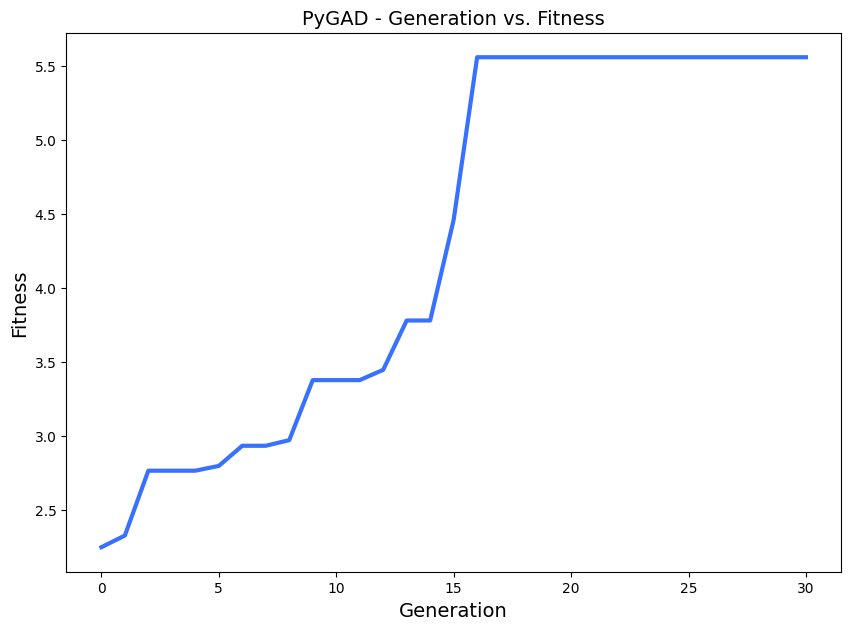

C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio = portfolio.groupby("Date", as_index=False).sum()
C:\Users\patri\AppData\Local\Temp\ipykernel_32756\290748195.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shou



daily_change:  0         NaN
1   -0.018650
2   -0.021279
3    0.005770
4    0.019653
5   -0.015091
6   -0.025439
7   -0.001209
8    0.011025
9    0.513199
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03             0   1.000000           NaN
1 2023-04-04             0   0.981691     -0.018650
2 2023-04-05             0   0.961237     -0.021279
3 2023-04-06             0   0.966816      0.005770
4 2023-04-10             0   0.986197      0.019653
5 2023-04-11             0   0.971536     -0.015091
6 2023-04-12             0   0.947434     -0.025439
7 2023-04-13             0   0.946290     -0.001209
8 2023-04-14             0   0.956839      0.011025
9 2023-04-17            18   1.965564      0.513199


daily_change:  0         NaN
1   -0.019634
2   -0.020876
3    0.003199
4    0.025340
5   -0.011776
6   -0.032833
7    0.011010
8    0.005933
9    0.009799
Name: daily_change, dtype: float64
portfolio:         Date  ticker_i

KeyError: -1

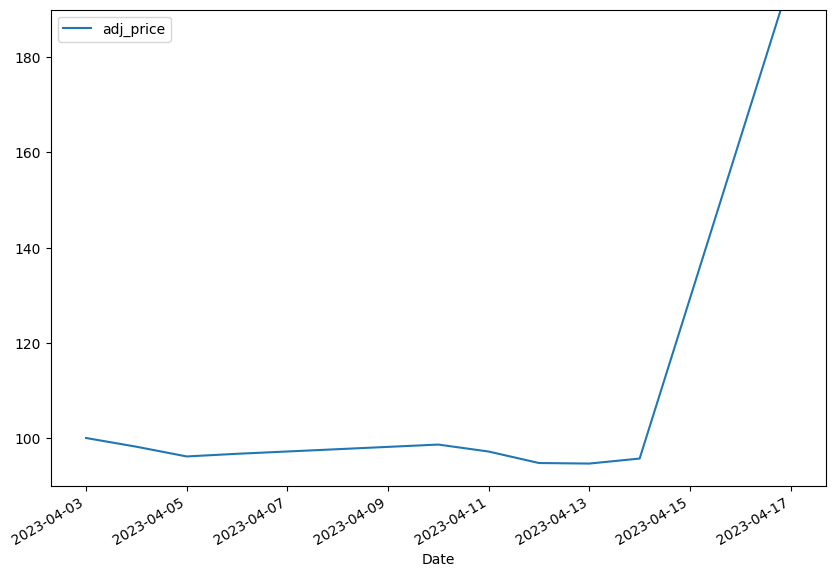

In [62]:
## Plot training, best resuls

ga_instance.plot_fitness(save_dir=None)
[solution, _, __] = ga_instance.best_solution()
visualize(df, solution)



daily_change:  0         NaN
1   -0.007501
2    0.004692
3    0.008463
4    0.013551
5    0.022995
6   -0.000406
7    0.022011
8    0.007851
9    0.014464
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index  adj_price  daily_change
0 2023-04-03          2355  10.000000           NaN
1 2023-04-04          2355   9.925546     -0.007501
2 2023-04-05          2355   9.972332      0.004692
3 2023-04-06          2355  10.057452      0.008463
4 2023-04-10          2355  10.195616      0.013551
5 2023-04-11          2355  10.435587      0.022995
6 2023-04-12          2355  10.431350     -0.000406
7 2023-04-13          2355  10.666125      0.022011
8 2023-04-14          2355  10.750526      0.007851
9 2023-04-17          2355  10.908303      0.014464


daily_change:  0         NaN
1   -0.007501
2    0.004692
3    0.008463
4    0.013551
5    0.022995
6   -0.000406
7    0.022011
8    0.007851
9    0.014464
Name: daily_change, dtype: float64
Parameters of the best solution :

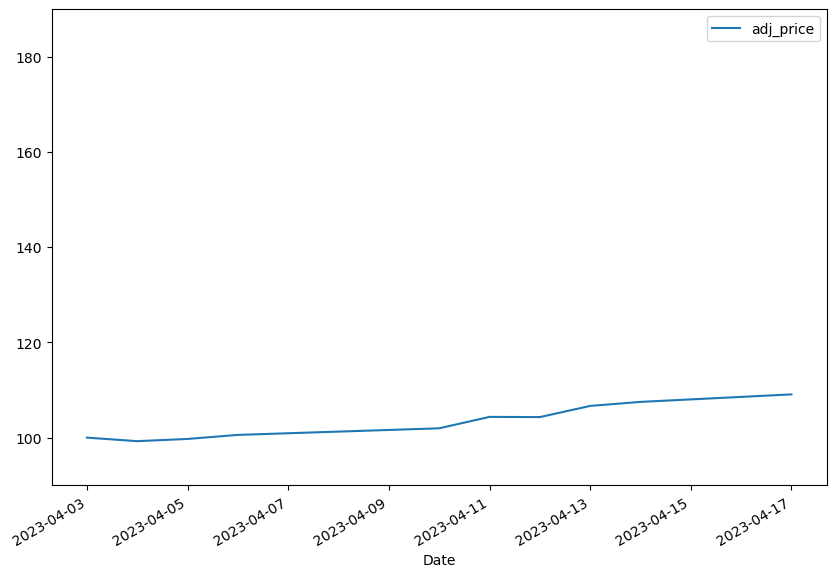

In [ ]:
## Top 10 performers benchmark

firsts = df.groupby("ticker_index", as_index=False).first()
firsts = firsts.rename({"adj_price": "first_price"}, axis=1)[["ticker_index", "first_price"]]
lasts = df.groupby("ticker_index", as_index=False).last()
lasts = lasts.rename({"adj_price": "last_price"}, axis=1)[["ticker_index", "last_price"]]

df_ = firsts.merge(lasts, on="ticker_index", how="left")
df_["return"] = df_["last_price"] / df_["first_price"]
df_ = df_.sort_values("return", ascending=False)
best_return = df_.head(10)["ticker_index"].unique()

visualize(df, best_return)



daily_change:  0         NaN
1   -0.010509
2   -0.002403
3    0.000692
4    0.006391
5    0.006369
6   -0.005324
7    0.007888
8   -0.004833
9    0.006827
Name: daily_change, dtype: float64
portfolio:         Date  ticker_index   adj_price  daily_change
0 2023-04-03        125250  501.000000           NaN
1 2023-04-04        125250  495.789721     -0.010509
2 2023-04-05        125250  494.601185     -0.002403
3 2023-04-06        125250  494.943600      0.000692
4 2023-04-10        125250  498.127311      0.006391
5 2023-04-11        125250  501.320114      0.006369
6 2023-04-12        125250  498.665120     -0.005324
7 2023-04-13        125250  502.630001      0.007888
8 2023-04-14        125250  500.212605     -0.004833
9 2023-04-17        125250  503.650781      0.006827


daily_change:  0         NaN
1   -0.010509
2   -0.002403
3    0.000692
4    0.006391
5    0.006369
6   -0.005324
7    0.007888
8   -0.004833
9    0.006827
Name: daily_change, dtype: float64
Parameters of the best

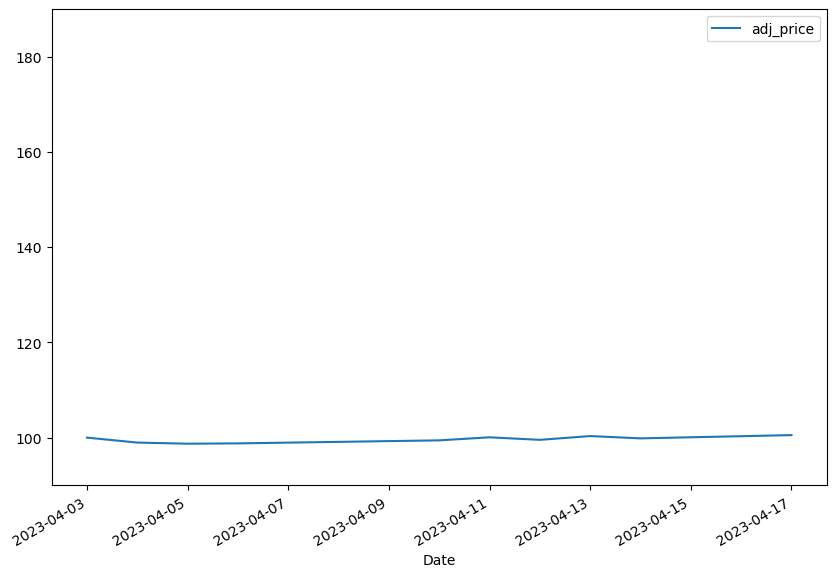

In [ ]:
## S&P 500 benchmark

visualize(df, df["ticker_index"].unique())